# RISER ANALYSIS
This note book covers the procedure to perform finite difference analysis to compute 'riser displacement' under the influence of current and wave forces.

A complete drilling riser analysis is a compilation of a number of analyses, which investigates the response of a drilling riser including the lateral riser displacement, riser angle, von-mises stress and bending moment for various environmental loads acting on the riser system. 
#### Important Considerations
* Riser system has to be designed according to **API RP 16Q**.
* Von Mises Stress must be limited to less than **67%** of the yeild stress.
* Riser system is modelled as tensioned beam.

 The notebook verifies the result of <u> Abimbola et al </u> and uses their paper as primary reference 
 <u>Abimbola, Fatai Akorede, Jin Yang, Shujie Liu, and Ting Sun. "Survivability study of deepwater drilling riser in freestanding mode." Ocean Engineering 222 (2021): 108634.</u>

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import gridspec 

In [2]:
#------------------------------
# Riser Properties
# Riser Material selected in API 5L X80
sig_max=    552                 # yield stress of material
sig_all=    0.67*sig_max        # Allowable stress i riser material
D_i=        1025                # Internal fluid density kg/m^3
#----------------------------------------
D_r=    7850                    # Density of riser material in kg/m^3
E=      210*(10**9)             # Elastic modulus of riser in N/m^2
Do=     533.4/1000              # Outer diameter of riser in meters
t=      15.875/1000             # Riser wall thickness in m
Di=     Do-(2*t)                # Inner diameter of riser in meters
Lr=     1485                    # Length of riser in connected mode
Lbm=    15                      # Height from mudline to riser bottom
h=      1                       # Divison length

# Buoyancy Can properties
Db=     6.95                    # Buoyancy can diameter in meter
Lb=     100                     # Buoyancy can length in meter
B_P=    150                     # Position of Buoyancy Can from sea level in meters

# Joint properties
Kbt=    103.13*(10**3)          # Rotational Stiffness in the upper flex joint in Nm/rad
Kbb=    1546.99*(10**3)         # Rotational Stiffness of the lower flex joint in Nm/rad

# Ocean, wave and Current data
D_s=    1025                    # Density of sea water in kg/m^3
d=      1500                    # Water depth in metere
H=      5                       # Wave height in m
Tw=     13                      # Wave period in s
L0=     1.56*(Tw**2)            # Deep water wave length in m
k=      2*np.pi/L0              # Wave number
U_t=    0.23                    # sea surface tide velocity in m/s
U_w=    1.91                    # sea surface wind velocity in m/s
Cd=     0.5                     # Drag Coefficient
Cm=     1.5                     # Inertia Coefficient
f_wt=1                          # Submerged weight Tolerence factor
f_bt=1                          # Buoyancy loss Tolerence factor
g=9.81                          # Acceleration due to gravity
N=int(d/h)

In [3]:
# Riser geometric properties
Dm=     (Do+Di)/2                   # Mean Diameter
Ae=     np.pi*(Do**2)/4             # External Area
Ai=     np.pi*(Di**2)/4             # Internal Area
Am=     np.pi*(Dm**2)/4             # Mean Area
Ab=     np.pi*(Db**2)/4             # Outer Area of buoyancy can
An=     np.pi*((Do**2)-(Di**2))/4   # Annular Area of riser
I=      np.pi*((Do**4)-(Di**4))/64  # Moment of inertia of Riser
Ma=     1.1                         # Added mass coefficient
Wa=     (D_r*An+Ai*D_i-Ae*D_s)*g    # Apparent weight in N/m

BCUR=   np.array([1,1.5,2,2.4,2.5,2.6,2.7])   # Buoyancy Can Upthrust Ratio
Btop=   BCUR*0.7*D_s*g*Ab*Lb
Bxt=    Lr+Lbm-B_P
Bxb=    Bxt-Lb

#### Current and Wave Velocity
Horizontal Wave Velocity, $$ u = \frac{\pi H}{T}\frac{coshk(d+z)}{T sinhkd}sin(\theta) $$
H : Wave height
T : Wave Period
d : Sea depth
Current Velocity, $$ u_c=u_{tc} (\frac{x+l_{bm}}{d})^{1/7} + u_{wc}(\frac{x+l_{bm}}{d})$$
$l_{bm}$ : height from mudline to riser bottom  
$u_{tc}$ : Sea surface tide velocity  
$u_{wc}$ : Sea surface wave velocity

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


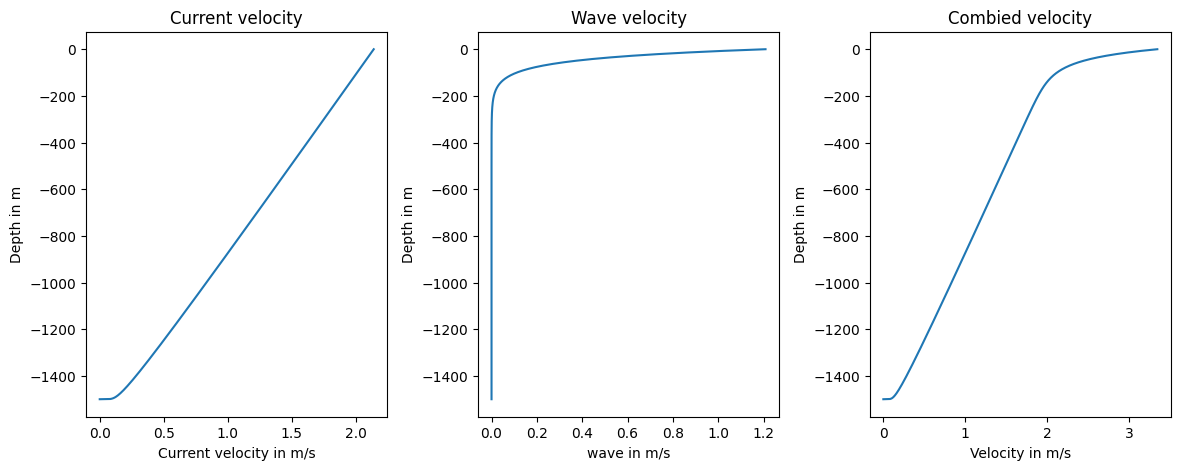

In [4]:
# Wave and Current Velocity calculation
Uc = np.zeros((N+3),dtype=np.complex_)
Uw = np.zeros((N+3),dtype=np.complex_)
U = np.zeros((N+3),dtype=np.complex_)

for x in range(0,d+1,h):
    tp=int(x/h+1)
    Uc[tp] = U_t * ((d - x) / d) ** (1/7) + U_w * ((d - x) / d)
    Uw[tp] = np.pi * H * np.cosh(k * (d - x)) / (Tw * np.sinh(k * d))
    U[tp] = Uc[tp] + Uw[tp]
Unc=Uc[1:N+2]
Unw=Uw[1:N+2] 
Un=U[1:N+2]    
# Plot wave, current and combined velocity
m = np.arange(0, d+1,h)                                         # Create depth values from 0 to d

plt.ion()
fig1 = plt.figure(figsize=(14, 5))
gs1  = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], hspace=0.3, wspace=0.3)

# Plot Current Velocity
ax1  = plt.subplot(gs1[0])
ax1.plot(Unc, -m)
ax1.set_title('Current velocity')
ax1.set_xlabel('Current velocity in m/s')
ax1.set_ylabel('Depth in m')

# Plot Wave Velocity
ax2  = plt.subplot(gs1[1])
ax2.plot(Unw, -m)
ax2.set_title('Wave velocity')
ax2.set_xlabel('wave in m/s')
ax2.set_ylabel('Depth in m')

# Plot combined veocity
ax3  = plt.subplot(gs1[2])
ax3.plot(Un,-m)
ax3.set_title('Combied velocity')
ax3.set_xlabel('Velocity in m/s')
ax3.set_ylabel('Depth in m')

plt.show()

#### External Pressure and Force Calculation

The external lateral current and force is calculated by
$$ f(x)=0.5\rho C_DD_eu_c|u_c|$$

The external pressure is calculated by
$$ P=\frac{\gamma H}{2}\frac{coshk(d+z)}{coshkd}sin(\theta)-\gamma Z$$


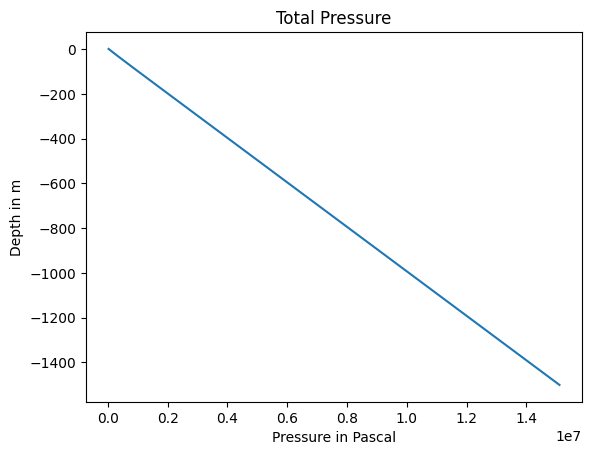

In [5]:
# Pressure and Force calculation
Pi=np.zeros(N+3)
P_Sta=np.zeros(N+3)
P_Dyn=np.zeros(N+3)
Po=np.zeros(N+3)
for x in range(0,N+3):
    Pi[x] = D_i * g * (x*h)
    P_Sta[x] = D_s * g * (x*h)
    P_Dyn[x] = D_s * H * np.cosh(k * (d - (x*h))) / (2 * np.cosh(k * d)) * g
    Po[x] = P_Sta[x] + P_Dyn[x]

mi=np.concatenate(([-1],m,[1501]))
plt.plot(Po,-mi)
plt.title('Total Pressure')
plt.xlabel('Pressure in Pascal')
plt.ylabel('Depth in m')

plt.show()

#### FINITE DIFFERENCE FORMULATION OF THE GOVERNING EQUATION

Governing Equation
$$ EI\partial^4_x y-T\partial^2_x y-W\partial^1_x y-f(x)=0$$
E = Modulus of Elasticity  
I = Moment of Inertia  
T = Effective Tension   
W = Apparent weight of riser  
f(x) = Force acting  
\
\
At node 0,
$$ EI\partial^2_x y=k_b\theta _b$$
$$ y=0$$
for this FDM transformation is $$v_{-1}-\frac{4EI}{2EI+K_bh}v+\frac{2EI-K_bh}{2EI+K_bh}v_1=0$$

At node n,
$$ EI\partial^2_x y=0$$
for this FDM transformation is $$v_{-1}-2v+v_{1}=0$$

At node n+1,
$$ EI\partial^3_x y-f_{vt}(x)=0$$
$f_{vt}$= force due to wave and other external parameters  
for this FDM transformation is $$-v_{n-2}+3v_{n-1}+3v_n+v_{n+1}=(h^3/EI)f_n$$

For internal nodes FDM formaulation use is,
$$EI\frac{v_{i+2}-4v_{i+1}+6v_i-4v_{i-1}+v_{i-2}}{h^4}-T_{ei}\frac{v_{i+1}-2v_i+v_{i-1}}{h^2}-W_a\frac{v_{i+1}-v_{i-1}}{2h}=f_i$$






C:\Users\ACER\AppData\Local\Temp\ipykernel_13940\1301215455.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  F[tp,0]=0.5*Cd*Do*D_s*Unc[tp-1]*abs(Unc[tp-1])*g
C:\Users\ACER\AppData\Local\Temp\ipykernel_13940\1301215455.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  F[tp,0]=0.5*Cd*Db*D_s*Unc[tp-1]*abs(Unc[tp-1])*g


<function matplotlib.pyplot.show(close=None, block=None)>

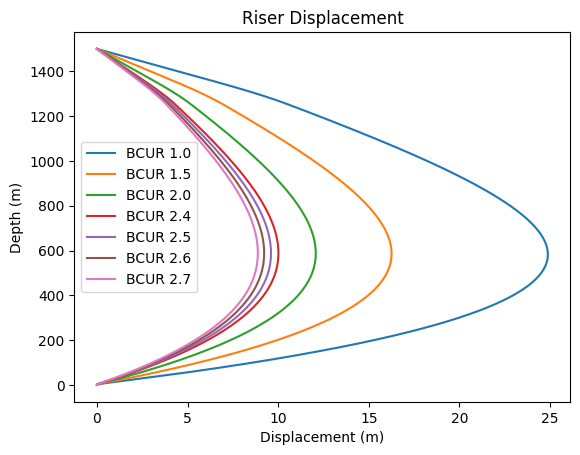

In [6]:
# Setting up Force vector
F=np.zeros((N+3,1))
for x in range(0,d+1,h):                # Setting force equal to force along riser at all nodes
    tp=int(x/h+1)              
    F[tp,0]=0.5*Cd*Do*D_s*Unc[tp-1]*abs(Unc[tp-1])*g
F[N+2,0]=((h**3)/E*I)*F[N+1,0]

for x in range(Bxb,Bxt+1,h):            # Setting force along buoyancy can 
    tp=int(x/h+1)
    F[tp,0]=0.5*Cd*Db*D_s*Unc[tp-1]*abs(Unc[tp-1])*g

Mode = input("Enter c if the riser is in connected mode\nEnter f if the riser is in freestanding mode: ")
# Loop for External Pressure calculation
T=np.zeros(N+3)
Tv=np.zeros((N+3,7))
K=np.zeros((N+3,N+3))
Y_Global=np.ones((N+3,1))
FR=np.zeros((N+1,7))
T_values = []
Y_G=[]
YF=np.zeros((N+1,7))
for b in range(len(BCUR)):
    for x in range(0,N+3):
        T[x] = Btop[b] - Wa * (Lr+Lbm - (x*h))
    Tv[:,b]=T
    T_values.append(T.copy())
    # Bottom boundry condition (1)
    K[0,0]=1
    K[0,1] =-(4*E*I)/((2*E*I)+(Kbb*h))
    K[0,2] =(2*E*I)-(Kbt*h)/((2*E*I)+(Kbt*h))
    F[0,0] =0
    # Bottom boundry condition (2)
    K[1,1] =1
    F[1,0] =0
    Y_Global[1,0] = 0
    # Top boundry condition (1)
    if Mode == 'c':                         # Connected Mode
        K[N+1, N] = ((2 * E * I) - (Kbt * h)) / ((2 * E * I) + (Kbt * h))
        K[N+1, N+1] = -(4 * E * I) / ((2 * E * I) + (Kbb * h))
        K[N+1, N+2] =1
        F[N+1,0] = 0
        Y_Global[N+2,0] = 0
    elif Mode == 'f':                       # Free standing mode
        K[N+1, N] = 1
        K[N+1, N+1] = -2
        K[N+1, N+2] = 1
        F[N+1,0] = 0
    # Top boundry condition (2)
    K[N+2, N+2] = 1
    K[N+2, N+1] = -3
    K[N+2, N] = 3
    K[N+2, N-1] = -1
    
    for x in range (2,N+1,h):
        
        K[x,x-2]=E*I/ (h**4)
        K[x,x-1]=-((4*E*I/(h**4))+(T[x]/(h**2))-(Wa/(2*h)))
        K[x,x]=(6*E*I/(h**4))+(2*T[x]/(h**2))
        K[x,x+1]=-((4*E*I/(h**4))+(T[x]/(h**2))+(Wa/(2*h)))
        K[x,x+2]=E*I/(h**4)
    
    # Solving for displacement y
    Y = np.dot(np.linalg.inv(K),F)
    YG=Y[1:-1]
    YF[:,b]=YG[:,0]
    Y_G.append((b,m,YG))

for i in range(len(BCUR)):
    plt.plot(YF[:,i],m,label=f'BCUR {BCUR[i]}')
plt.xlabel('Displacement (m)')
plt.ylabel('Depth (m)')
plt.legend()
plt.title('Riser Displacement')
plt.show

#### Calculation for, Angle of deflection along Riser, Stress Calulation

Angle of deflection $$\theta = \partial_x y=\frac{y_{x+1}-y_{x-1}}{2h}\frac{180}{\pi}$$
Bending Stress $$\sigma_{bi}=\frac{M_iR_{mw}}{I}$$
Axial Stress $$\sigma_a=\frac{T_{ei}}{A_e+A_i}$$
Circumferential Stress $$\sigma_c=\frac{P_iA_i+P_eA_e}{A_e+A_i}+\frac{(P_i-P_e)A_iA_e}{(A_e+A-i)A_m}$$
Radial Stress $$\sigma_r=\frac{P_iA_i+P_eA_e}{A_e+A_i}-\frac{(P_i-P_e)A_iA_e}{(A_e+A_i)A_m}$$

##### Supporting Formulae
The Apparent weight,$$W_a=m_rg+A_i\rho_ig-A_e\rho_eg$$
The effective tension,$$T_e(x)=B_{top}-W_a(L-x)$$
$$B_{top}=0.7\rho_w g\frac{\pi}{4}D_{bc}^2L_{bc}$$
Minimum Top Tension, $$ T_{min}=\frac{T_{ei}N}{R_f(N-n)}$$
$N$ number of tensioners supporting the riser<br>
$n$  number of tensioners sudden fails<br>
$R_f$  0.9 to 0.95<br>
Dynamic tension limit,$$ DTL=P_A A_{cyl} N_{LP}$$
$P_A$ Maximum Allowable system<br>
$A_{cyl}$ Effective hydraulic area<br>
$N_{LP}$ Number of line parts<br>





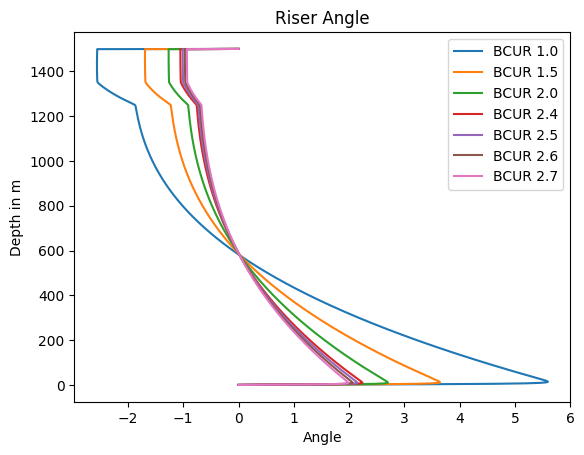

In [7]:
# Angle of Deflection along riser And Stress Calculation
Angle=np.zeros((N+1,7))
s_t=np.zeros((N+1,7))
s_b=np.zeros((N+1,7))
s_a=np.zeros((N+1,7))
s_c=np.zeros((N+1,7))
s_r=np.zeros((N+1,7))
sig_von=np.zeros((N+1,7))
BM=np.zeros((N+1,7))
for c in range(0,7,1):
    for x in range(1,N,h):
        Angle[x,c]=(YF[x+1,c]-YF[x-1,c])/(2*h)*180/np.pi                    # Angle Calculation
        s_t[x,c]=Tv[x,c]/(Ae-Ai)                                            # Tension stress
        s_b[x,c]=(YF[x+1,c]-2*YF[x,c]+YF[x-1,c])*Dm/(2*I*h**2)              # Bending Stress
        s_a[x,c]=s_t[x,c]+s_b[x,c]                                          # Total axial stress
        s_c[x,c]=((Pi[x]*Ai-Po[x]*Ae)/(Ae-Ai))+(((Pi[x]-Po[x])*Ai*Ae)/((Ae-Ai)*Am)) # Circumferential stress
        s_r[x,c]=((Pi[x]*Ai-Po[x]*Ae)/(Ae-Ai))-(((Pi[x]-Po[x])*Ai*Ae)/((Ae-Ai)*Am)) # Radial stress
        sig_von[x,c]=0.5*math.sqrt((s_a[x,c]-s_c[x,c])**2+(s_c[x,c]-s_r[x,c])**2+(s_r[x,c]-s_a[x,c]**2))*0.25/10**6     # von mises stress
        BM[x,c]=sig_von[x,c]*I*2/Dm*1000

for i in range (len(BCUR)):
    plt.plot(Angle[:,i],m,label=f'BCUR {BCUR[i]}')
plt.title('Riser Angle')
plt.ylabel('Depth in m')  
plt.xlabel('Angle')
plt.legend()  
plt.show()


In [8]:
y=np.amax(YF)
sig_max=np.amax(sig_von)
a=np.amax(Angle)

if sig_max < sig_all:
    print("The riser is safe")
else:
    print("The riser is unsafe")

The riser is safe


# CONCLUSION
Deepwater drilling riser system analysis is quite complex and is required to define operational limits and top tension requirements under in-service loadings. In this study,drilling riser system analysis is carried out to obtain the riser displacement, riser angle.
The drilling riser dimensions and configurations which are satisfying acceptance criteria described in the American Petroleum Institute Recommendation practice for Design, Selection, Operation and Maintenance of Drilling Riser Systems code book are proposed.
Eighty percent of the result obtained in the design project is matching with the results in the reference paper. Such that the result of BCUR greater than 1.5 are almost matching for riser displacement and riser angle with the reference paper. Further analysis establishment is required to obtain the more approximate result as in the reference research paper.

